# MLP Basic mit MNIST

In dieser Übung verwenden wir Pytorch, um MLP zu erstellen. Der Vorteil besteht darin, dass wir selbst keinen Optimierer oder Backpropagation schreiben müssen. Bevor Sie mit der Übung beginnen, installieren Sie zunächst Torchvision, das bereits den MNIST-Datensatz enthält. Wir müssen keine zusätzlichen Datensätze herunterladen.

In [ ]:
#import sys
#!conda install --yes --prefix {sys.prefix} torchvision

In [9]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
from sklearn.model_selection import train_test_split

## Datensatzvorbereitung
Laden Sie Trainings- und Validierungsdaten des MNIST Datensatz mithilfe des torchvison Pakets
- Machen Sie sich mit dem MNIST Datensatz vertraut; 
- Welche Form haben die Eingabe und Ausgabe Werte, bringen Sie diese in eine geeignette Form zur Verarbeitung in einem Fully-Connected NN.
- Es geht nicht um die Güte der Lösung, sondern das prinzipielle Vorgehen --> Falls Ihre Rechenleistung nicht für den gesamten Datensatz ausreicht nehmen Sie nur einen Teil der Daten. 

In [6]:
transform = transforms.Compose([
    # you can add other transformations in this list for Visualisierung (Data Modifiezieren, for Rauschen machen, bei laden Tranformieren vorverarbeitet)
    transforms.ToTensor()
])

root = 'data/'
training_dataset = datasets.MNIST(root, train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root, train=False, download=False, transform=transform) #eigentlich soll es auf Test nennen.

Führen Sie den folgenden Code aus, um die Form des Datensatzes zu beobachten und die Bedeutung jeder Dimension zu erklären. Versuchen Sie, ein Bild zur Visualisierung auszuwählen

In [7]:
X_train, y_train = training_dataset.data, training_dataset.targets
X_val, y_val = validation_dataset.data, validation_dataset.targets

print("Full Dataset:\n")
print("Input-Shape Training Data:     ", X_train.shape)
print("Output-Shape Training Data:    ",y_train.shape)
print("Input-Shape Test Data:         ",X_val.shape)
print("Output-Shape Test Data:        ",y_val.shape ,"\n")

Full Dataset:

Input-Shape Training Data:      torch.Size([60000, 28, 28])
Output-Shape Training Data:     torch.Size([60000])
Input-Shape Test Data:          torch.Size([10000, 28, 28])
Output-Shape Test Data:         torch.Size([10000]) 



## Dataloader

- Erstellen sie eine Instanz eines Dataloaders für jede der Datensplits
  > [Beispiel](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)

In [38]:
train_dataloader = DataLoader(training_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=True)

- Plotten sie einen Batch und die entsprechende Labels

In [24]:
x_features, x_labels = next(iter(train_dataloader))

Feature batch shape: torch.Size([8, 1, 28, 28])
Labels batch shape: torch.Size([8])


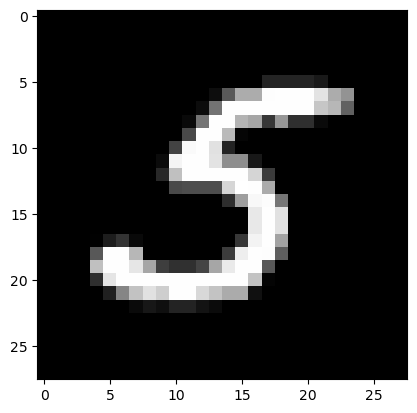

Label: 5


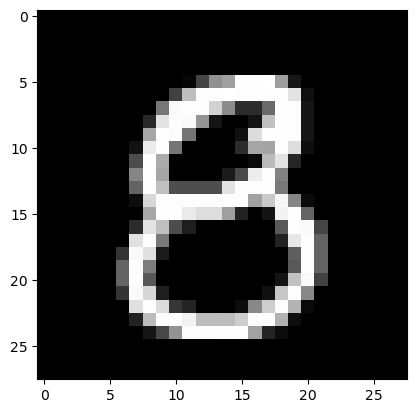

Label: 8


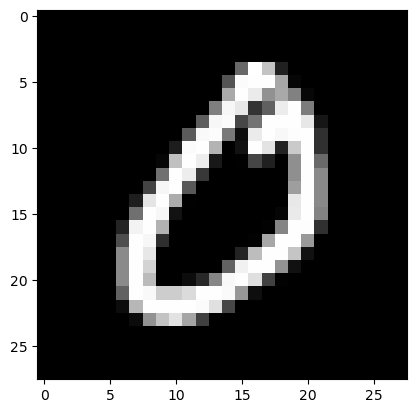

Label: 0


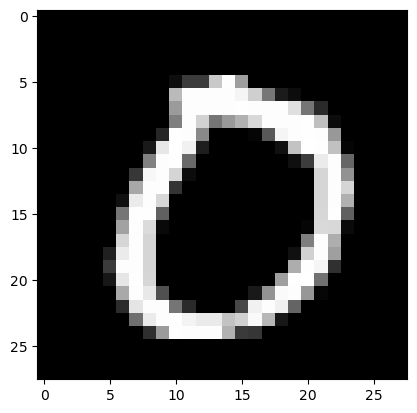

Label: 0


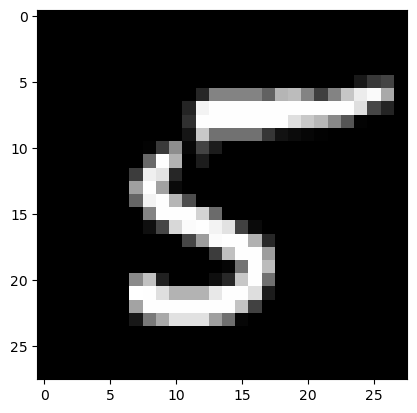

Label: 5


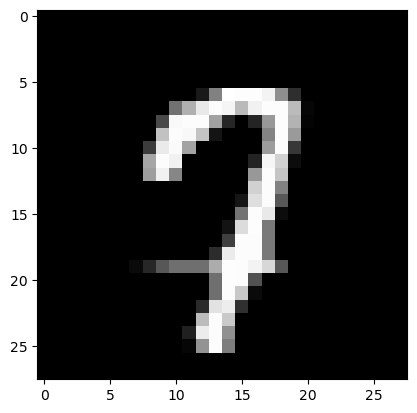

Label: 7


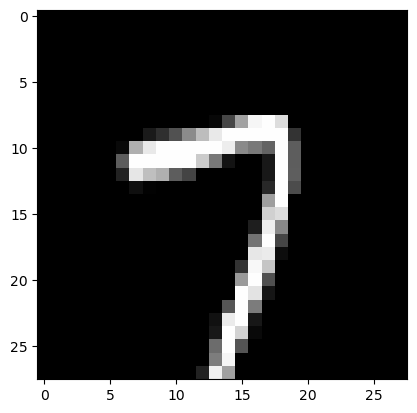

Label: 7


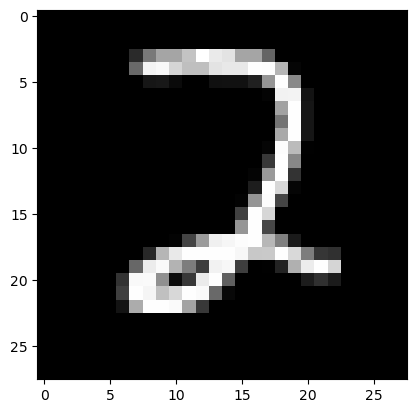

Label: 2


In [29]:
print(f"Feature batch shape: {x_features.size()}") # 1 for black-white channel
print(f"Labels batch shape: {x_labels.size()}")
for i in range(train_dataloader.batch_size):
    img = x_features[i].squeeze()
    label = x_labels[i]
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")

## Das Modell trainieren
- Verwenden der Pytorch-Bibliothek zum Erstellen eines MLP über die Funktion nn.Linear 

In [31]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_1_size, hidden_2_size, output_size):
        super().__init__()
        self.hidden1 = nn.Linear(input_size, hidden_1_size)
        self.hidden2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.output = nn.Linear(hidden_2_size, output_size)
    def forward(self, x):
        output_hidden_1 = torch.sigmoid(self.hidden1(x))
        output_hidden_2 = torch.sigmoid(self.hidden2(output_hidden_1))
        return torch.sigmoid(self.output(output_hidden_2))
    def predict(self, x):           #Klassifizierung 10 Klassen
        y_pred = self.forward(x)
        return torch.argmax(y_pred, dim=1)

Führen Sie den folgenden Code aus, um die Modelldekonstruktion zu sehen. Sie können versuchen, die Größe und Anzahl der 'hidden layer' zu ändern.

In [32]:
torch.manual_seed(2)

hidden_1_size = 50
hidden_2_size = 50

input_size = 28*28
output_size = 10

model = MLP(input_size, hidden_1_size, hidden_2_size, output_size)
model

MLP(
  (hidden1): Linear(in_features=784, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=10, bias=True)
)


- Versuchen Sie die Lernrate $lr$ zu ändern und beobachten Sie der Loss-Wert während des Trainings.
  >Hier beträgt die Lernrate 0.001
- Wählen Sie eine geeignete Loss/Fehler-Funktionimplementieren Sie eine Gütefunktion um die Genauigkeit der Schätzung zu prüfen
- Verwenden Sie einen anderen Optimierer
  >Hier wird SGD genutzt
  >https://pytorch.org/docs/stable/optim.html#base-class
  >Adam mit variable Lernrate
  >In der praxis mehrere Optimizer benutzen

In [33]:
lr = 1e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

- Ergänzen Sie die Trainingsloop mit der Berechnung der [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy?hl=de) für jede Epoche.
- Plotten Sie sowohl der Loss-Wert als auch die Accuracy für jede Epoche, um die Lernkurve darzustellen

In [34]:
def accuracy(y_pred, y_true):
    acc= torch.mean((y_pred == y_true).float())
    return acc

## Trainingsprozess starten

In [49]:
#Accuracy hinzufügen
template = '[Ep {}] Loss={:.4f}/{:.4f} Accuracy={:.4f}/{:.4f}'

epochs = 50

loss_epoch = []
valid_loss_epoch = []
accuracy_epoch = []
valid_accuracy_epoch = []
batch_size = train_dataloader.batch_size

for i_epoch in range(epochs):

    loss_list = []
    accuracy_list = []
    
    for X_batch, y_batch in train_dataloader:
        
        X_batch = X_batch.reshape(batch_size, -1)
        y_pred = model(X_batch)
        print(y_pred.shape)
        print(y_batch.shape)
        loss = criterion(y_pred, y_batch)
        loss_list.append(loss.item())
        accuracy = accuracy(y_pred, y_batch)
        accuracy_list.append(accuracy.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss_train = np.mean(loss_list)
    loss_epoch.append(mean_loss_train)
    mean_accuracy_train = np.mean(accuracy_list)
    valid_accuracy_epoch.append(mean_accuracy_train)

    loss_list = []
    accuracy_list = []
    
    with torch.no_grad():
        for X_batch, y_batch in valid_dataloader:
            X_batch = X_batch.reshape(batch_size, -1)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss_list.append(loss.item())
            accuracy = accuracy(y_pred, y_batch)
            accuracy_list.append(accuracy.item())

    mean_loss_valid = np.mean(loss_list)
    mean_accuracy_valid = np.mean(accuracy_list)
    valid_loss_epoch.append(mean_loss_valid)
    valid_accuracy_epoch.append(mean_accuracy_valid)

    print(template.format(i_epoch+1, mean_loss_train, mean_accuracy_train, mean_accuracy_valid))

torch.Size([8, 10])
torch.Size([8])


RuntimeError: The size of tensor a (10) must match the size of tensor b (8) at non-singleton dimension 1

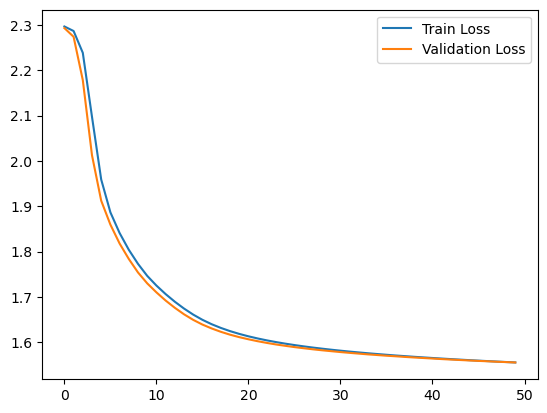

In [40]:
plt.figure()
plt.plot(loss_epoch, label='Train Loss')
plt.plot(valid_loss_epoch, label='Validation Loss')
plt.legend()
plt.show()

# TODO: Plot Accuracy

## Test Model

In [41]:
x_, y_ = next(iter(valid_dataloader))

In [45]:
y_pred_val = model.predict(x_.reshape(valid_dataloader.batch_size, -1))
y_pred_val

tensor([6, 9, 8, 7, 1, 9, 0, 5])

In [46]:
y_

tensor([2, 9, 8, 7, 1, 9, 0, 5])